In [1]:
#import modules
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import openpyxl
import datetime

In [2]:
#start_analysis = input("What date would you like to start YYYY-MM-DD :")

In [3]:
#end_analysis = input("What date would you like to end YYYY-MM-DD :")

In [4]:
raw_oil = pd.read_excel('Brent_Oil.xls',sheet_name='Data 1',skiprows=2)

In [5]:
raw_shipping = pd.read_excel('Shipping TCE.xlsx',skiprows=4)

In [6]:
#rename the columns as they are too long, do this step by step so the code is not too long

In [7]:
raw_shipping.rename(columns={'1 Year Timecharter Rate 310,000 dwt D/H VLCC':'VLCC'},inplace=True)
raw_shipping.rename(columns={'1 Year Timecharter Rate 74,000 dwt LR1 Products Tanker':'LR1'},inplace=True)
raw_shipping.rename(columns={'1 Year Timecharter Rate MR Products Tanker (Long Run Historical Series)':'MR'},inplace=True)
raw_shipping.rename(columns={'Unnamed: 0':'Date'},inplace=True)


In [8]:
print(raw_shipping.head())

                  Date   VLCC    LR1     MR
0                 Date  $/day  $/day  $/day
1  1988-01-01 00:00:00    NaN    NaN   9000
2  1988-02-01 00:00:00    NaN    NaN   9075
3  1988-03-01 00:00:00    NaN    NaN   9100
4  1988-04-01 00:00:00    NaN    NaN   8820


In [9]:
#drop the $/day label row
raw_shipping.drop(0,axis=0,inplace=True)

In [10]:
#convert the dates to datetime so that they can be used later to join data
raw_shipping['Date'] = pd.to_datetime(raw_shipping['Date'],format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [11]:
print(raw_shipping.head())

        Date VLCC  LR1    MR
1 1988-01-01  NaN  NaN  9000
2 1988-02-01  NaN  NaN  9075
3 1988-03-01  NaN  NaN  9100
4 1988-04-01  NaN  NaN  8820
5 1988-05-01  NaN  NaN  9000


In [12]:
#the data has empty rows for VLCC and LR1. For proper analysis I will drop the rows with nil values so all vessel types can be reviews
shipping_adj = raw_shipping.dropna()


In [13]:
#the index is also not set on the dates, so I will set the index to be the date
shipping_adj.set_index('Date', inplace=True)

In [14]:
print(shipping_adj)


             VLCC      LR1        MR
Date                                
2000-05-01  35625    15375   13437.5
2000-06-01  39300    16200     13950
2000-07-01  41875    17250     14125
2000-08-01  43875  17437.5   14812.5
2000-09-01  45400    17700     15450
...           ...      ...       ...
2022-02-01  17125    13625  12468.75
2022-03-01  17125    15125   13687.5
2022-04-01  15800    15900     15350
2022-05-01  16000  18437.5     17500
2022-06-01  16000    22750     19500

[266 rows x 3 columns]


In [15]:
#as I'm taking data from multiple sources, I want to ensure the data is in the same timeseries
#the shipping data that I have is a monthly average, therefore all my other data should be a monthly average

In [16]:
print(raw_oil.head())

        Date  Europe Brent Spot Price FOB (Dollars per Barrel)
0 1987-05-20                                             18.63
1 1987-05-21                                             18.45
2 1987-05-22                                             18.55
3 1987-05-25                                             18.60
4 1987-05-26                                             18.63


In [17]:
raw_oil['Date'] = pd.to_datetime(raw_oil['Date'])
df_oil = raw_oil.set_index('Date')
df_oil_monthly = df_oil.resample('M').mean()

In [18]:
print(df_oil_monthly.head())

            Europe Brent Spot Price FOB (Dollars per Barrel)
Date                                                        
1987-05-31                                         18.580000
1987-06-30                                         18.860476
1987-07-31                                         19.856522
1987-08-31                                         18.979524
1987-09-30                                         18.313182


In [19]:
#shipping rates are start of month, yet oil data is end of month. I am going to adjust the dates in shipping to be end of month
shipping_eom = shipping_adj.resample('M').last()
print(shipping_eom)

               VLCC      LR1        MR
Date                                  
2000-05-31  35625.0  15375.0  13437.50
2000-06-30  39300.0  16200.0  13950.00
2000-07-31  41875.0  17250.0  14125.00
2000-08-31  43875.0  17437.5  14812.50
2000-09-30  45400.0  17700.0  15450.00
...             ...      ...       ...
2022-02-28  17125.0  13625.0  12468.75
2022-03-31  17125.0  15125.0  13687.50
2022-04-30  15800.0  15900.0  15350.00
2022-05-31  16000.0  18437.5  17500.00
2022-06-30  16000.0  22750.0  19500.00

[266 rows x 3 columns]


In [20]:
#as a wider economic indicator, I am going to use the S&P500
#to do this I am going to take dat from yahopo finance

#as an interest rate tracker, I am going to use the Vanguard Short Term Bond Index Fund (VBI)
#seeks to track the investment performance of the Bloomberg U.S. 1–5 Year Government/Credit Float Adjusted Index

SP500 = '^GSPC'
VBI = 'VBISX'

Name1= 'SP500'
Name2 = 'VBI'

#SP_tick = yf.Ticker('^GSPC')
#SP_data = pd.DataFrame(SP_tick.history(start="2000-01-01"))
#SP_data.rename(columns={'Close':'SP500'},inplace=True)

In [21]:
def get_data(ticker):
    #pull the stock ticker details
    stock = yf.Ticker(ticker)
    #get the historic date, and turn it into pandas dataframe
    data = pd.DataFrame(stock.history(start="2000-01-01",end="2022-06-01",interval="1wk"))
    #rename the columns so that they can later be merged and can still be identified
    data.rename(columns = {'Close':'Close '+str(ticker)},inplace = True)
    #filter down the data to only the columns that I need
    df_ticker = data[['Close '+str(ticker)]]
    #return the result of the function. Own note, you need to have something be returned or when you call a function it goes nowhere
    df_ticker_monthly = df_ticker.resample('M').mean()
    return df_ticker_monthly

In [22]:
#df_SP_monthly = SP_data.resample('M').mean()
#SP500_monthly = df_SP_monthly['SP500']

In [23]:
df_sp500 = get_data(SP500)
df_vbi = get_data(VBI)

df_sp500.rename(columns={'Close ^GSPC':'SP500'},inplace=True)
df_vbi.rename(columns={'Close VBISX':'VBI'},inplace=True)

In [24]:
#after continuing to search for data, I was able to find historical Daily Sterling overnight index average (SONIA) rate. I will now add this to my analysis for a benchmark interest rate
#this data comes from the Bank of England so will be a proper measure of interest rate correlation

In [25]:
raw_sonia = pd.read_csv('SONIA.csv')
raw_sonia['Date'] = pd.to_datetime(raw_sonia['Date'])
raw_sonia.set_index('Date', inplace=True)
raw_sonia.rename(columns={'Daily Sterling overnight index average (SONIA) rate              [a]             IUDSOIA':'SONIA'},inplace=True)
df_sonia = raw_sonia.resample('M').mean()

In [26]:
print(df_sp500.head())

                  SP500
Date                   
2000-01-31  1426.502002
2000-02-29  1368.934998
2000-03-31  1471.394958
2000-04-30  1438.502026
2000-05-31  1420.797485


In [27]:
#merge the datasets 
shipping_oil = shipping_eom.merge(df_oil_monthly,on='Date',how='left')
consol_sp = shipping_oil.merge(df_sp500,on='Date',how='left')
#consol_vbi = consol_sp.merge(df_vbi,on='Date',how='left')
consol_data = consol_sp.merge(df_sonia,on='Date',how='left')

In [28]:
print(consol_data.head())

               VLCC      LR1       MR  \
Date                                    
2000-05-31  35625.0  15375.0  13437.5   
2000-06-30  39300.0  16200.0  13950.0   
2000-07-31  41875.0  17250.0  14125.0   
2000-08-31  43875.0  17437.5  14812.5   
2000-09-30  45400.0  17700.0  15450.0   

            Europe Brent Spot Price FOB (Dollars per Barrel)        SP500  \
Date                                                                        
2000-05-31                                         27.737619  1420.797485   
2000-06-30                                         29.795455  1454.372467   
2000-07-31                                         28.682381  1470.378003   
2000-08-31                                         30.196087  1497.694977   
2000-09-30                                         33.144762  1450.906006   

               SONIA  
Date                  
2000-05-31  5.912205  
2000-06-30  5.903173  
2000-07-31  5.986705  
2000-08-31  5.884623  
2000-09-30  6.125881  


In [29]:
#names of the final two columns are too long. Rename them to Brent Oil Price and 3ML
consol_data.rename(columns={'Europe Brent Spot Price FOB (Dollars per Barrel)':'Brent Oil Price'},inplace=True)

In [30]:
print(consol_data)

               VLCC      LR1        MR  Brent Oil Price        SP500     SONIA
Date                                                                          
2000-05-31  35625.0  15375.0  13437.50        27.737619  1420.797485  5.912205
2000-06-30  39300.0  16200.0  13950.00        29.795455  1454.372467  5.903173
2000-07-31  41875.0  17250.0  14125.00        28.682381  1470.378003  5.986705
2000-08-31  43875.0  17437.5  14812.50        30.196087  1497.694977  5.884623
2000-09-30  45400.0  17700.0  15450.00        33.144762  1450.906006  6.125881
...             ...      ...       ...              ...          ...       ...
2022-02-28  17125.0  13625.0  12468.75        97.129000  4370.257568  0.419885
2022-03-31  17125.0  15125.0  13687.50       117.245217  4439.087524  0.562283
2022-04-30  15800.0  15900.0  15350.00       104.575263  4281.583887  0.690642
2022-05-31  16000.0  18437.5  17500.00       113.337619  4053.910034  0.915786
2022-06-30  16000.0  22750.0  19500.00       123.007

<function matplotlib.pyplot.show(close=None, block=None)>

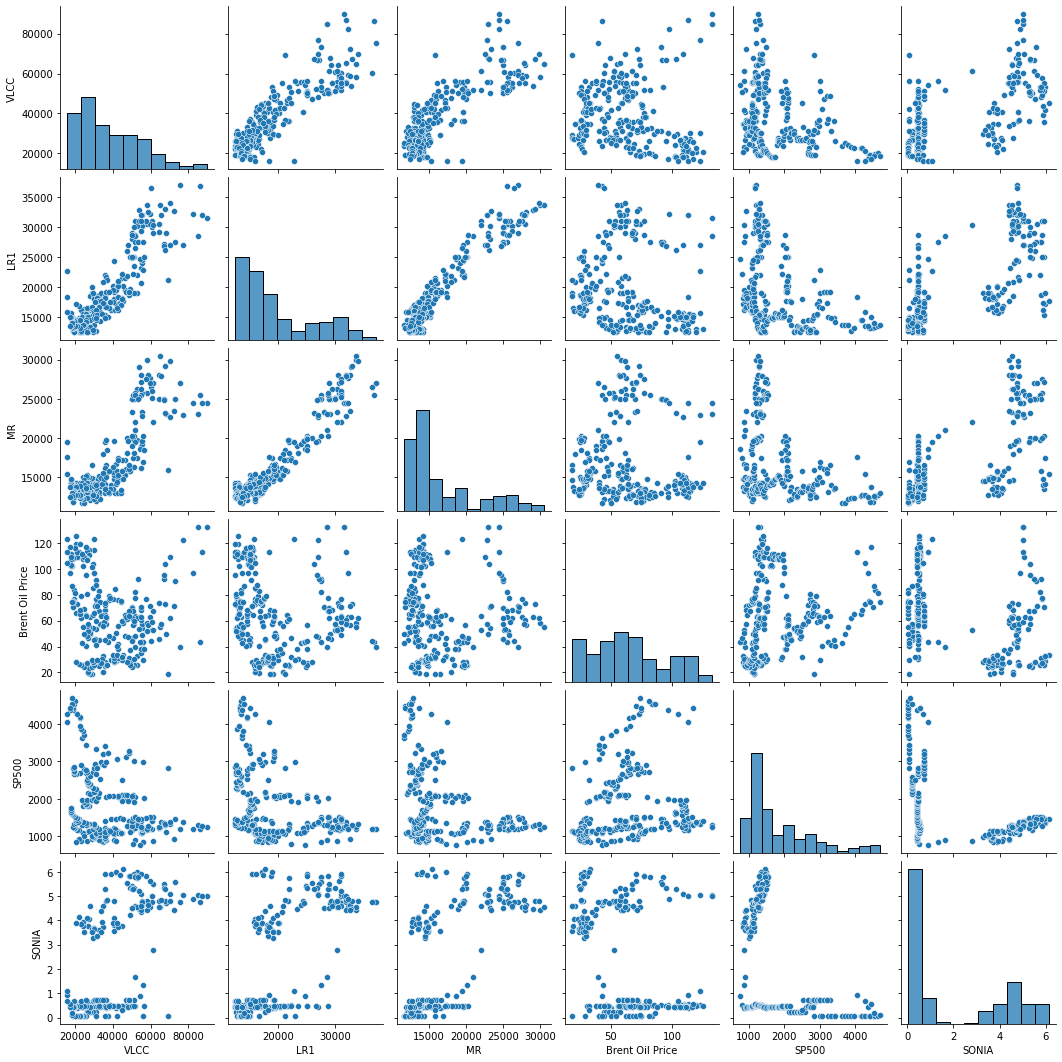

In [31]:
#utilise sns pairplot to see at aglance if there are any obvious relationships
sns.pairplot(consol_data,kind='scatter')
plt.show

In [32]:
LT_Corr = consol_data.corr()

<AxesSubplot:>

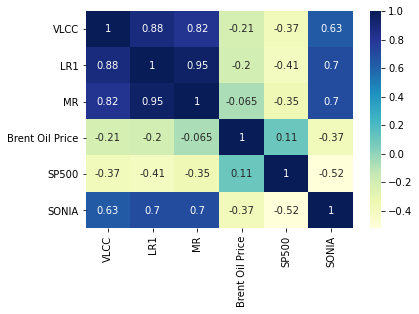

In [33]:
sns.heatmap(LT_Corr, annot=True, cmap="YlGnBu")

In [34]:
#now see how much Covid19 impacted these correlations

In [35]:
#import the covid data from the csv
raw_covid = pd.read_csv('covid_cases.csv')
raw_covid['Date'] = pd.to_datetime(raw_covid['Date'])
raw_covid.set_index('Date', inplace=True)

In [36]:
#print(raw_covid.head())
#filter and summarise the data in line with out existing data

In [37]:
raw_covid_filtered = raw_covid[['Confirmed']]

In [38]:
print(raw_covid_filtered.head())

            Confirmed
Date                 
2020-01-22        555
2020-01-23        654
2020-01-24        941
2020-01-25       1434
2020-01-26       2118


In [39]:
df_covid_monthly = raw_covid_filtered.resample('M').sum()
df_covid_monthly.rename(columns={'Confirmed':'Covid Cases'},inplace=True)

In [40]:
print(df_covid_monthly.tail())

            Covid Cases
Date                   
2020-08-31     24759879
2020-09-30     25291846
2020-10-31     25829914
2020-11-30     26347267
2020-12-31     26857045


In [41]:
#now I want to get a "splitter" date value, so I can assess the pre and post covid correlations, and create two dataframes based on this split date

In [42]:
covid_start = df_covid_monthly.index.min()

In [43]:
print(covid_start)

2020-01-31 00:00:00


In [44]:
#use the date above to generate a pre and post covid dataset

pre_covid = consol_data[consol_data.index <= covid_start]
post_covid = consol_data[consol_data.index >= covid_start]
post_covid = post_covid.merge(df_covid_monthly, on='Date',how='left')

<AxesSubplot:>

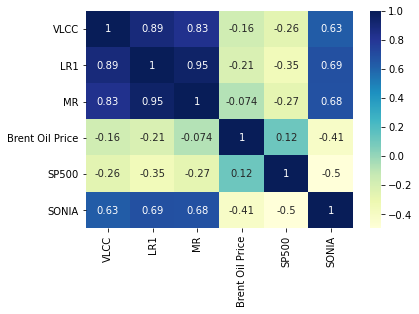

In [45]:
Pre_Corr = pre_covid.corr()
sns.heatmap(Pre_Corr, annot=True, cmap="YlGnBu")

<AxesSubplot:>

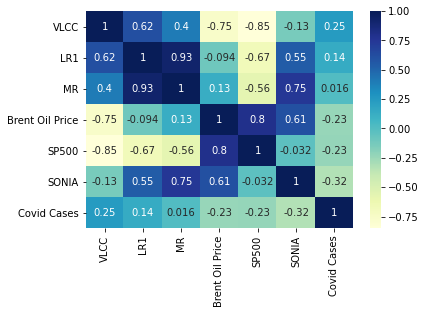

In [46]:
Post_Corr = post_covid.corr()
sns.heatmap(Post_Corr, annot=True, cmap="YlGnBu")

<AxesSubplot:>

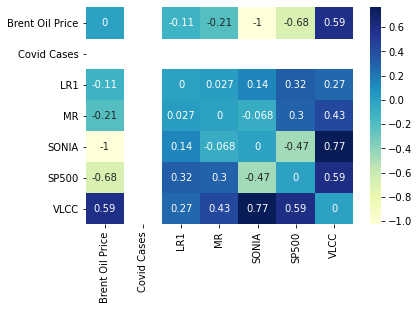

In [47]:
Delta_Corr = pre_covid.corr() - post_covid.corr()
sns.heatmap(Delta_Corr, annot=True, cmap="YlGnBu")

In [48]:
#generate graphs to show the correlations on individual line charts to better illustrate relationships
#note that this involves plotting three datasets on the Y-axis, and the creation of a secondary y-axis for the variable we want to show

def get_graph(dataframe, factor):
    graph = sns.lineplot(x=dataframe.index.values, y='MR',data=dataframe)
    plt.xlabel("Date")
    plt.ylabel("TCE $/day")
    date_form = DateFormatter("%m-%Y")
    graph.xaxis.set_major_formatter(date_form)
    plt.xticks(rotation=90)
    graph.plot(dataframe.index.values,dataframe.LR1, label='LR1')
    graph.plot(dataframe.index.values,dataframe.VLCC, label='VLCC')
    graph2 = graph.twinx()
    sns.lineplot(x=dataframe.index.values, y=factor,ax=graph2, data=dataframe, label=factor, linestyle='dashed')
    plt.legend(loc='upper right')
    #graph.legend(labels=['MR','LR1','VLCC'])
    graph.legend(labels=['MR','LR1','VLCC'], loc='upper left')
    graph_dataframe = graph
    plt.show()

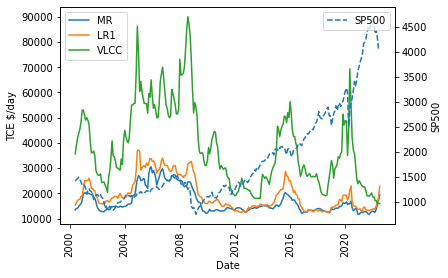

In [49]:
get_graph(consol_data,'SP500')

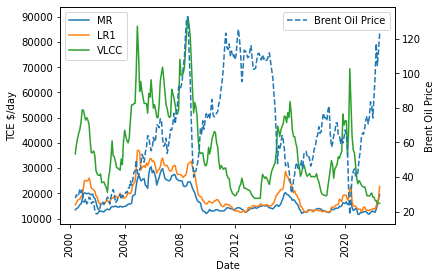

In [50]:
get_graph(consol_data,'Brent Oil Price')

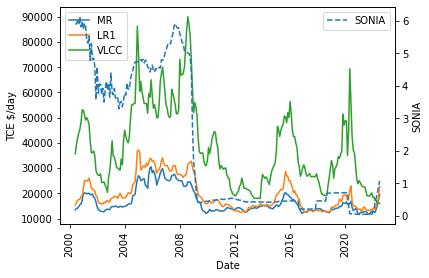

In [51]:
get_graph(consol_data,'SONIA')

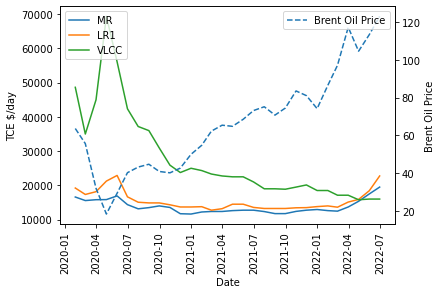

In [61]:
get_graph(post_covid,'Brent Oil Price')

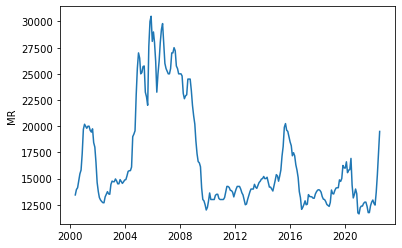

In [53]:
mr_solo = sns.lineplot(x=consol_data.index.values, y='MR',data=consol_data)

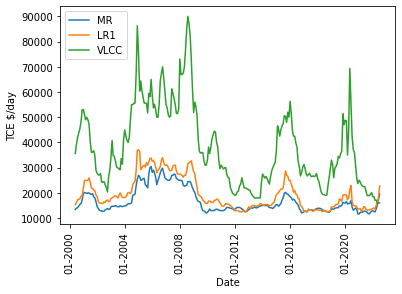

In [55]:
#for illustrative purposes a graph of only shipping rates to illustrate they are correlated

graph_rates = sns.lineplot(x=consol_data.index.values, y='MR',data=consol_data)
plt.xlabel("Date")
plt.ylabel("TCE $/day")
date_form = DateFormatter("%m-%Y")
graph_rates.xaxis.set_major_formatter(date_form)
plt.xticks(rotation=90)
graph_rates.plot(consol_data.index.values,consol_data.LR1, label='LR1')
graph_rates.plot(consol_data.index.values,consol_data.VLCC, label='VLCC')
graph_rates.legend(labels=['MR','LR1','VLCC'], loc='upper left')
plt.show()